# Optimizing the Photo-fenton model using Deep Reinforcement Learning

In this notebook we show an example of optimizing the Photo-fenton model using a PPO agent with "balanced" memory configuration and "random" initialization (called DB-R).

We also provide .py files of all agent configuration from this work. These .py files should be run from terminal and must be configured using the exp_config.yaml file.

```bash
python <file.py> <path to folder containing exp_config.yaml>
```

E. g.: An optimization of peroxide model using a PPO agent with "balanced" memory of experiences and "random"
initialization should be run as:

```bash
python Agent_DB-R.py ./
```


In [5]:
import os
import sys

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from RL_Agent import ppo_agent_continuous_parallel
from utils.preprocess import *
from utils import hyperparameters as hyperparams
from RL_Problem import rl_problem
from src.environments import perox_complete_model_small_glob_coord
import global_enviroment_log as glob
import datetime as dt
import yaml
import matplotlib.pyplot as plt

Let's configure the algorithm parameters. When running out of binder you should use the exp_config.yaml file for this purpose.

Here we explain each parameter:

In [6]:
actor_lr = 1e-5  # actor network learning rate
critic_lr = 1e-5  # critic network learning rate
batch_size =  128  # batch size for training the network
exploration_noise = 5.0  # Maximum value of std in exploration
epsilon = 1.0  # Exploration rate
epsilon_decay = 0.8   # Exploration decay rate. Rate decay by multipliying epsilon * epsilon_decay
epsilon_min = 0.09  # Minimum value for epsilon.
memory_size = 40  # Number of experiences stored in memory for each training step
histogram_memory = True  # Whether use histogram (or balanced) memory configuration.
n_stack = 20  # Number of states from previous time steps used as inputs to the neural network.
n_threads = 12  # Number of parallel executions.
iter = 252  # Full iterations. Round*n_threads = iter

sodis_params = "src/environments/fotocaos_complete_model/sodis_params.txt"  # File to the sodis parameters

experiment_path = "experiments/"  # path to save the logs

Load model fixed data:

In [7]:
glob.traj_path = experiment_path

log_alpha_values_init = [1e-5, 1e-5, 1e-5, -15., 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1, 1]

f = open(sodis_params, "r")
sodis_params = f.read()
sodis_params = sodis_params.split('\n')
sodis_params = [float(sodis_params[i]) for i in range(len(sodis_params)-1)]

# Assign Sodis params
log_alpha_values_init[6] = sodis_params[0]
log_alpha_values_init[10] = sodis_params[1]
log_alpha_values_init[13] = np.trunc(sodis_params[2])

Build the reinforcement learning environment. This entity includes the Photo-fenton model.

In [8]:
m_peroxide = perox_complete_model_small_glob_coord.env(sodis=False,
                                                       perox=True,
                                                       bact=False,
                                                       log_alpha_values_init=log_alpha_values_init,
                                                       log_scale=False)

/home/serch/TFM/RLPhotoFentonOptimization/src/environments/fotocaos_complete_model/modelo_completo_perox_interfaz_v2.py:361: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nuevos_index.append(np.array(index_aux))
/home/serch/TFM/RLPhotoFentonOptimization/src/environments/fotocaos_complete_model/modelo_completo_perox_interfaz_v2.py:365: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nuevos_index.append(np.array(index_aux))


Define the neural network architecture.

In [11]:
def lstm_custom_model_actor(input_shape):
    actor_model = Sequential()
    actor_model.add(LSTM(128, input_shape=input_shape, activation='tanh'))
    actor_model.add(Dense(256, input_shape=input_shape, activation='relu'))
    actor_model.add(Dense(256, input_shape=input_shape, activation='relu'))
    actor_model.add(Dense(128, activation='relu'))
    return actor_model

def lstm_custom_model_critic(input_shape):
    actor_model = Sequential()
    actor_model.add(LSTM(128, input_shape=input_shape, activation='tanh'))
    actor_model.add(Dense(256, input_shape=input_shape, activation='relu'))
    actor_model.add(Dense(128, activation='relu'))
    return actor_model

net_architecture = hyperparams.actor_critic_net_architecture(use_custom_network=True,
                                                        actor_custom_network=lstm_custom_model_actor,
                                                        critic_custom_network=lstm_custom_model_critic,
                                                        )

Build a PPO agent.

In [12]:
agent = ppo_agent_continuous_parallel.Agent(actor_lr=actor_lr,
                                            critic_lr=critic_lr,
                                            batch_size=batch_size,
                                            exploration_noise=exploration_noise,
                                            epsilon=epsilon,
                                            epsilon_decay=epsilon_decay,
                                            epsilon_min=epsilon_min,
                                            memory_size=memory_size,
                                            net_architecture=net_architecture,
                                            n_stack=n_stack,
                                            n_step_return=20,
                                            histogram_memory=histogram_memory,
                                            tensorboard_dir=None,
                                            n_parallel_envs=n_threads
                                            )

Build a reinforcement learning problem with an environment (the model) and an agent.

In [13]:
problem = rl_problem.Problem(m_peroxide, agent)


Custom network option selected: {use_custom_network:  True , custom_network:  <function lstm_custom_model_actor at 0x7f62cf8b7950> }
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_input (InputLayer)         [(None, 20, 245)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 128)          191488      lstm_input[0][0]                 
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          33024       lstm[0][0]                       
________________________________________

Set a preprocessing function.

In [15]:
problem.preprocess = perox_only_norm
problem.compile()

Execute the optimization process. Note that a histogram of the memory is shown when using balanced memory. This histogram shows the number of states for each reward value.

Start time 2022-05-02 20:28:17.030852
Episode  1 Epochs  40  Reward -235.8 Smooth Reward -262.8  Epsilon 1.0000
Episode  2 Epochs  40  Reward -235.4 Smooth Reward -262.8  Epsilon 1.0000
Episode  3 Epochs  40  Reward -306.3 Smooth Reward -262.8  Epsilon 1.0000
Episode  4 Epochs  40  Reward -317.2 Smooth Reward -262.8  Epsilon 1.0000
Episode  5 Epochs  40  Reward -234.8 Smooth Reward -262.8  Epsilon 1.0000
Episode  6 Epochs  40  Reward -210.8 Smooth Reward -262.8  Epsilon 1.0000
Episode  7 Epochs  40  Reward -245.0 Smooth Reward -262.8  Epsilon 1.0000
Episode  8 Epochs  40  Reward -276.9 Smooth Reward -262.8  Epsilon 1.0000
Episode  9 Epochs  40  Reward -327.2 Smooth Reward -262.8  Epsilon 1.0000
Episode  10 Epochs  40  Reward -244.5 Smooth Reward -262.8  Epsilon 1.0000
Episode  11 Epochs  40  Reward -243.5 Smooth Reward -262.8  Epsilon 1.0000
Episode  12 Epochs  40  Reward -276.2 Smooth Reward -262.8  Epsilon 1.0000


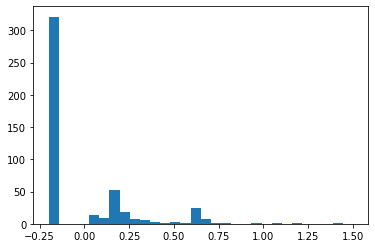

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/serch/TFM/RLPhotoFentonOptimization/RL_Agent/base/PPO_base/ppo_agent_base.py:393: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  global_error = np.array(self.best_params_fotocaos_list)[:, 1]


Actor loss 787.3103678385417 0
Critic loss 1554.588045247396 0
Episode  13 Epochs  40  Reward -253.2 Smooth Reward -259.7  Epsilon 0.8000
Episode  14 Epochs  40  Reward -255.9 Smooth Reward -259.7  Epsilon 0.8000
Episode  15 Epochs  40  Reward -255.0 Smooth Reward -259.7  Epsilon 0.8000
Episode  16 Epochs  40  Reward -244.4 Smooth Reward -259.7  Epsilon 0.8000
Episode  17 Epochs  40  Reward -265.9 Smooth Reward -259.7  Epsilon 0.8000
Episode  18 Epochs  40  Reward -286.3 Smooth Reward -259.7  Epsilon 0.8000
Episode  19 Epochs  40  Reward -223.7 Smooth Reward -259.7  Epsilon 0.8000
Episode  20 Epochs  40  Reward -256.4 Smooth Reward -259.7  Epsilon 0.8000
Episode  21 Epochs  40  Reward -276.1 Smooth Reward -259.7  Epsilon 0.8000
Episode  22 Epochs  40  Reward -286.1 Smooth Reward -259.7  Epsilon 0.8000
Episode  23 Epochs  40  Reward -224.2 Smooth Reward -259.7  Epsilon 0.8000
Episode  24 Epochs  40  Reward -252.7 Smooth Reward -259.7  Epsilon 0.8000


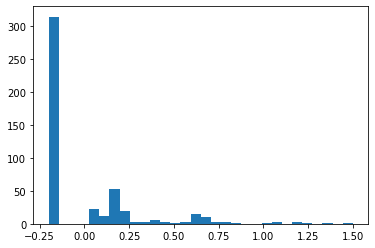

Actor loss 536.1685233738111 1
Critic loss 1054.2254712975543 1
End time 2022-05-02 20:29:50.074157
Optimization time 0:01:33.043305


In [16]:
start_time = dt.datetime.now()
print('Start time', start_time)

problem.solve(iter, render=False)

end_time = dt.datetime.now()
opt_time = end_time - start_time

print('End time', end_time)
print('Optimization time', opt_time)

Show the best set of params found for the peroxide model.

In [20]:
best_parallel_params_list = problem.env.get_best_params()

params_list = []
for params in best_parallel_params_list:
    params_list.extend(params)

if len(params_list) > 0:
    ind_best = np.argmin(np.array(params_list)[:, 1])
    model_params, model_error = params_list[ind_best][0], params_list[ind_best][1]

print('Peroxide params (K_M_P): ', model_params)
print('Peroxide model error: ', model_error)

Peroxide params (K_M_P):  [-0.53922129 -1.46990596 -0.7196868   0.85200202 -2.10898331]
Model error:  0.4295404604460738


Next we are going to optimize the bacteria model. First thing we need is to assign the optimized parameters of the peroxide model.

In [21]:
log_alpha_values_init[0] = model_params[0]
log_alpha_values_init[1] = model_params[1]
log_alpha_values_init[2] = model_params[2]
log_alpha_values_init[4] = model_params[3]
log_alpha_values_init[5] = model_params[4]

Let's configure the algorithm parameters for the bacteria model optimization.

Here we explain each parameter:

In [28]:
actor_lr = 1e-5  # actor network learning rate
critic_lr = 1e-5  # critic network learning rate
batch_size =  128  # batch size for training the network
exploration_noise = 5.0  # Maximum value of std in exploration
epsilon = 1.0  # Exploration rate
epsilon_decay = 0.8   # Exploration decay rate. Rate decay by multipliying epsilon * epsilon_decay
epsilon_min = 0.09  # Minimum value for epsilon.
memory_size = 40  # Number of experiences stored in memory for each training step
histogram_memory = True  # Whether use histogram (or balanced) memory configuration.
n_stack = 20  # Number of states from previous time steps used as inputs to the neural network.
n_threads = 12  # Number of parallel executions.
iter =  252  # Full iterations. Round*n_threads = iter

Let's build the environment for the bacteria model.

In [29]:
m_bacteria = perox_complete_model_small_glob_coord.env(sodis=False,
                                                       perox=False,
                                                       bact=True,
                                                       log_alpha_values_init=log_alpha_values_init,
                                                       log_scale=False)

Next we create a new agent to start a new optimization process as we did in our experiments. We could also use the previous agent pretrained in the peroxide model.

In [30]:
bacteria_agent = ppo_agent_continuous_parallel.Agent(actor_lr=actor_lr,
                                            critic_lr=critic_lr,
                                            batch_size=batch_size,
                                            exploration_noise=exploration_noise,
                                            epsilon=epsilon,
                                            epsilon_decay=epsilon_decay,
                                            epsilon_min=epsilon_min,
                                            memory_size=memory_size,
                                            net_architecture=net_architecture,
                                            n_stack=n_stack,
                                            n_step_return=20,
                                            histogram_memory=histogram_memory,
                                            tensorboard_dir=None,
                                            n_parallel_envs=n_threads
                                            )

Build a reinforcement learning problem with an environment (the model) and an agent.

In [31]:
bacteria_problem = rl_problem.Problem(m_bacteria, agent)

Set a preprocessing function.

In [32]:
bacteria_problem.preprocess = bact_only_norm
bacteria_problem.compile()

Execute the optimization process. Note that a histogram of the memory is shown when using balanced memory. This histogram shows the number of states for each reward value.

Start time 2022-05-02 20:51:22.976605
Episode  1 Epochs  40  Reward -29.3 Smooth Reward -26.5  Epsilon 0.6400
Episode  2 Epochs  40  Reward -26.9 Smooth Reward -26.5  Epsilon 0.6400
Episode  3 Epochs  40  Reward -24.6 Smooth Reward -26.5  Epsilon 0.6400
Episode  4 Epochs  40  Reward -29.1 Smooth Reward -26.5  Epsilon 0.6400
Episode  5 Epochs  40  Reward -27.9 Smooth Reward -26.5  Epsilon 0.6400
Episode  6 Epochs  40  Reward -30.7 Smooth Reward -26.5  Epsilon 0.6400
Episode  7 Epochs  40  Reward -24.9 Smooth Reward -26.5  Epsilon 0.6400
Episode  8 Epochs  40  Reward -26.7 Smooth Reward -26.5  Epsilon 0.6400
Episode  9 Epochs  40  Reward -25.5 Smooth Reward -26.5  Epsilon 0.6400
Episode  10 Epochs  40  Reward -24.3 Smooth Reward -26.5  Epsilon 0.6400
Episode  11 Epochs  40  Reward -28.3 Smooth Reward -26.5  Epsilon 0.6400
Episode  12 Epochs  40  Reward -19.4 Smooth Reward -26.5  Epsilon 0.6400


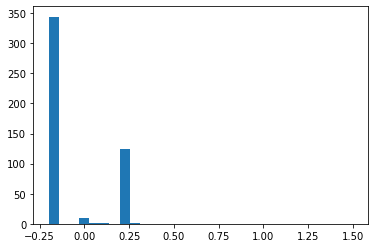

Actor loss 9.382786750793457 0
Critic loss 18.123781331380208 0
End time 2022-05-02 21:01:25.857537
Optimization time 0:10:02.880932


In [33]:
start_time = dt.datetime.now()
print('Start time', start_time)

bacteria_problem.solve(iter, render=False)

end_time = dt.datetime.now()
opt_time = end_time - start_time

print('End time', end_time)
print('Optimization time', opt_time)

Show the best set of params found for the bacteria model.

In [34]:
best_parallel_params_list = bacteria_problem.env.get_best_params()

params_list = []
for params in best_parallel_params_list:
    params_list.extend(params)

if len(params_list) > 0:
    ind_best = np.argmin(np.array(params_list)[:, 1])
    model_params, model_error = params_list[ind_best][0], params_list[ind_best][1]

print('Bacteria params (K_M_B): ', model_params)
print('Bacteria model error: ', model_error)

Bacteria params (K_M_B):  [-2.75451015 -2.2871863   3.91588467 -3.68481549 13.        ]
Bacteria model error:  3.883637674357221


Show results:

/home/serch/TFM/RLPhotoFentonOptimization/src/environments/fotocaos_complete_model/modelo_completo_perox_interfaz.py:489: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nuevos_index.append(np.array(index_aux))
/home/serch/TFM/RLPhotoFentonOptimization/src/environments/fotocaos_complete_model/modelo_completo_perox_interfaz.py:493: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nuevos_index.append(np.array(index_aux))


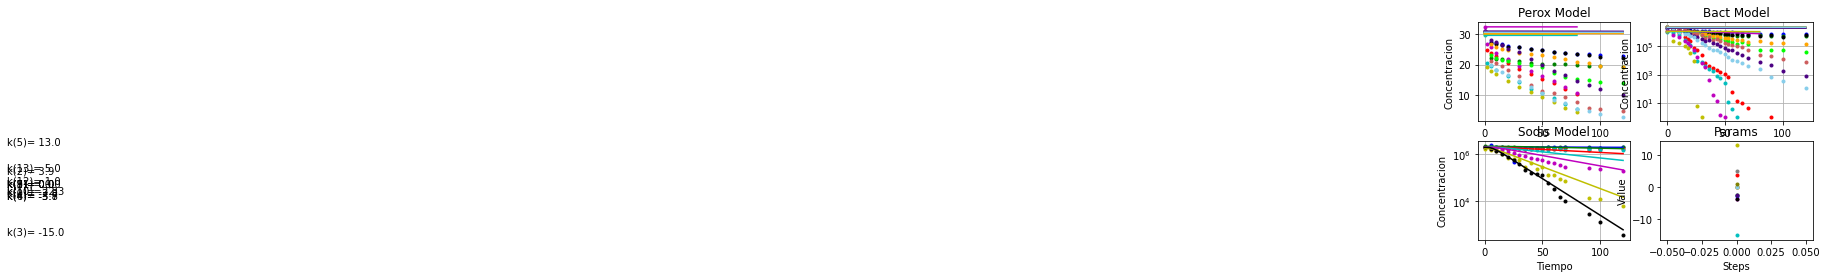

In [35]:
from src.environments.fotocaos_complete_model import modelo_completo_perox_interfaz
model = modelo_completo_perox_interfaz.ModeloCinetico(perox=True, bact=True, sodis=True,
                                                      params_to_optimize=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
log_alpha_values_init[0] = model_params[0]
log_alpha_values_init[1] = model_params[1]
log_alpha_values_init[2] = model_params[2]
log_alpha_values_init[4] = model_params[3]
log_alpha_values_init[5] = model_params[4]
params = log_alpha_values_init

error, curvas, params = model.reset(params=np.array(params))
model.render(error, curvas, params, 0., perox=True, bact=True, sodis=True)
plt.show()
plt.savefig('model_fitted.png')